In [1]:
# Import libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
def add_poly_terms(feat, n_feats=None, max_pot=5):
    # This function add polynomial terms up to max_pot power to the first n_feats
    # variables to the features' matrix up to the max_pot power
    n_samples = feat.shape[0]
    if n_feats is None:
        n_feats = feat.shape[1]
    feat_list = [feat]
    for pot in range(2, max_pot+1):
        feat_list +=  [np.reshape(feat[:,i]**pot, (n_samples,1)) for i in range(n_feats)]
    return np.concatenate(feat_list, axis=1)

def add_iter_terms(feat, n_feats=None):
    # This function add iteration terms of the first n_feats
    # variables to the features' matrix
    n_samples = feat.shape[0]
    if n_feats is None:
        n_feats = feat.shape[1]
    feat_list = [feat]
    for i in range(n_feats):
        for j in range(i+1,n_feats):
            feat_list += [np.reshape(feat[:,i]*feat[:,j], (n_samples,1))]
    return np.concatenate(feat_list, axis=1)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_rates(cm, classes):
    success_rate = []
    for i in range(len(cm)):
        success_rate.append(cm[i][i] / np.sum(cm[i]))
    
    x_pos = np.arange(len(classes))
    
    fig, ax = plt.subplots()    
    plt.bar(x_pos, success_rate)
    plt.xticks(x_pos, classes, rotation=45)
    ax.yaxis.set_visible(False)
    ax.axis([-1, 6, 0, 1.1])
    plt.title('Success rate for each class')
    #plt.ylabel('Success rate')
    for i, v in enumerate(success_rate):
        ax.text(i, v+0.01, format(success_rate[i], '.2f'),
                horizontalalignment="center",
                color='black', fontweight='bold')    
    plt.show()
    
# Eliminate NaN entries
def remove_nan(X):
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_mean, inds[1])
    
def normalize_data(X):
    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    return sc_X.fit_transform(X)

In [14]:
# read the data set
data_set = pd.read_csv('WISDM_ar_v1.1_transformed.csv')
X = data_set.iloc[:, 2:-1].values # eliminate not important colums 
y = data_set.iloc[:,-1].values

In [15]:
# Eliminate NaN entries
remove_nan(X)

In [16]:
# Feature scaling
X_unormalized = X
X = normalize_data(X)

In [17]:
# Split the dataset into the Training set and the Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)
classes = np.unique(y_train)

# From the confusion matrix I saw that the standard SVM and Logistic Regression classifiers had problems in identifying the 'Upstairs' and the 'Dowstairs' classes.
# So I tried to duplicate these classes' occurences in the training set in order to better identify them
# Comparing the results showed that this was irrelevant

In [19]:
# duplicate entries of classes 'Dpstairs' and 'Downstairs' 

#X_downstairs = X_train[y_train == 'Downstairs']
#X_upstairs = X_train[y_train == 'Upstairs']

#X_train = np.concatenate((X_train, X_downstairs, X_upstairs))
#y_train = np.concatenate((y_train, np.tile(['downstairs'], len(X_downstairs)),
#                                   np.tile(['upstairs'], len(X_upstairs))))

#idx_shuffle = np.random.permutation(len(X_train))
#X_train = X_train[idx_shuffle]
#y_train = y_train[idx_shuffle]

In [20]:
# Here I tried to give different weights for 'Upstairs' and 'Downstairs' classes
# but the overall accuracy decreased
dic = {}
for class_name in classes:
    if class_name == 'Upstairs' or class_name == 'Downstairs':
        dic[class_name] = 2
    else:
        dic[class_name] = 1

In [22]:
# 10-fold CV to assess Logistic Regression model
clf = LogisticRegression(random_state=0, class_weight='balanced') # balanced to take in account the low number of observations for 'Upstairs' et 'Downstairs' classes
scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Logistic Regression score on training set (10-fold CV): %f' % scores.mean())

Logistic Regression score on training set (10-fold CV): 0.756398


In [23]:
# Fit Logistic Regression classifier on training set
clf.fit(X_train, y_train)

# Predicting classes on test set and evaluate accuracy 
y_pred = clf.predict(X_test)
print('Logistic Regression score on test set: %f' % (np.mean(y_pred == y_test)))

Logistic Regression score on test set: 0.754613


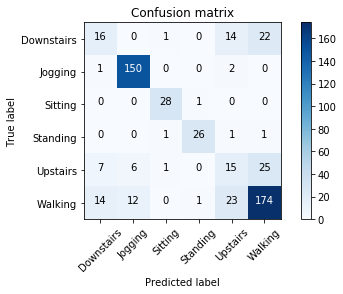

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=classes,title='Confusion matrix')

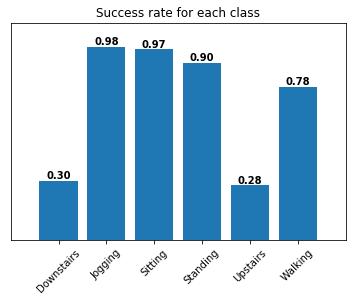

In [25]:
print_rates(cm, classes)

In [26]:
def CV_poly_degree_iter_terms(X, y, n_feats=None, max_pot=5):
    if n_feats is None:
        n_feats = X.shape[1]
        
    table_CV = np.zeros((max_pot, 2))
    clf = LogisticRegression(random_state=0, class_weight='balanced')
    table_CV[0,0] = cross_val_score(clf, normalize_data(X), y, cv=10).mean()
    table_CV[0,1] = cross_val_score(clf, normalize_data(add_iter_terms(X, n_feats=n_feats)), y, cv=10).mean()
    for i in range(2, max_pot+1):
        x = add_poly_terms(X, n_feats=43, max_pot=i)
        table_CV[i-1,0] = cross_val_score(clf, normalize_data(x), y, cv=10).mean()
        table_CV[i-1,1] = cross_val_score(clf,
                           normalize_data(add_iter_terms(x, n_feats=n_feats)), y, cv=10).mean()
    return table_CV
        
table_CV = CV_poly_degree_iter_terms(X_unormalized, y, n_feats=43, max_pot=5)
print(table_CV)

[[ 0.71898407  0.71403491]
 [ 0.75535747  0.73488358]
 [ 0.76254737  0.73783771]
 [ 0.76588278  0.74061004]
 [ 0.7642185   0.74226919]]


In [33]:
# Here I expand the data set to include polynomial terms of the predictors and evaluate the result
X_extended = data_set.iloc[:, 2:-1].values
remove_nan(X_extended)
X_extended = add_poly_terms(X_extended, n_feats=43, max_pot=5)
X_extended = add_iter_terms(X_extended, n_feats=43)
X_extended = normalize_data(X_extended)

# Split the dataset into the Training set and the Test set
from sklearn.model_selection import train_test_split
X_traine, X_teste, y_traine, y_teste = train_test_split(X_extended, y, test_size=0.10, random_state=0)

# Perform k-fold CV for model assessment
clfe = LogisticRegression(random_state=0, class_weight='balanced')
#scorese = cross_val_score(clfe, X_traine, y_traine, cv=10)

#print('CV score for LR model including polynomial terms (10-fold CV): %f' % scorese.mean())

In [35]:
clfe.fit(X_traine, y_traine)
y_prede = clfe.predict(X_teste)
print('Logistic Regression score on test set for model including poly/iter terms: %f' % (np.mean(y_prede == y_teste)))

Logistic Regression score on test set for model including poly/iter terms: 0.835793


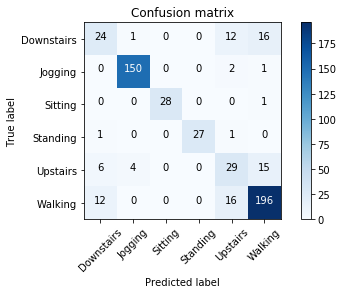

In [15]:
# Confusion matrix
cme = confusion_matrix(y_teste, y_prede)
plot_confusion_matrix(cme, classes=classes,title='Confusion matrix')

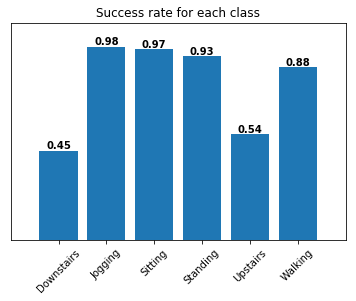

In [16]:
print_rates(cme, classes)